In [1]:
using Plots
using LinearAlgebra
using StatsBase
using Random
using Base.Threads

# Lucas Schmidt Ferreira de Araujo

$$ \min_x \|x\|_1 + \frac{\alpha}{2} \|Kx - y\|_2^2, $$

where $\alpha > 0$ is the regularization parameter. Define:

$$ f(x) = \frac{\alpha}{2} \|Kx - y\|_2^2 \quad \text{(smooth part)} $$

$$ g(x) = \|x\|_1 \quad \text{(non-smooth part)} $$

The proximal gradient iteration is:

$$ x^{k+1} = \operatorname{prox}_{\gamma g}\big(x^k - \gamma \nabla f(x^k)\big) $$ 

$$ \nabla f(x) = \alpha K^T (Kx - y) $$

where $\gamma$ is the step size. It is required that

$$ \gamma < \frac{2}{L}, \quad L =  \alpha  ||K ||_{2}^2$$


Proximal operator of $g(x) = \|x\|_1$ (soft-thresholding):
$$ \operatorname{prox}_{\gamma \|\cdot\|_1}(v) = \operatorname{sign}(v) \cdot \max(|v| - \gamma, 0) $$


In [5]:
function soft_thresholding(v, thresh)
    return sign.(v) .* max.(abs.(v) .- thresh, 0)
end

function prox_grad_l1(K, y, α , β; max_iter=10000, tol=1e-6)
    N = size(K, 2)
    x = zeros(N)
    L = α * opnorm(K, 2)^2
    γ = β / L
    for k in 1:max_iter
        grad = α * K' * (K * x - y)
        x_new = soft_thresholding(x - γ * grad, γ)
        if norm(x_new - x) < tol
            break
        end
        x = x_new
    end
    return x
end

function X_Rec(p , q , N ; αMAX = 200 , Ln = 2 , nα = 25 , nβ = 15 , σ = 0.0)
    s = round(Int , p * N )            
    M = round(Int , q * N)     
    x = zeros(N)
    idx = randperm(N)[1:s]
    x[idx] = randn(s) 
    K = randn(M, N)
    K .= K ./ sqrt.(sum(K.^2, dims=1))
    y = K * x + σ * randn(size(K, 1))
    β = range(10e-3,1,nβ)
    α = range(10e-3,αMAX,nα)
    err_ = 10e2
    errors_prox = zeros(length(α), length(β))
    errors_tikn = zeros(length(α) )
    @Threads.threads for i in 1:length(α)
        x_tikn = ((K' * K) + α[i] * I) \ (K' * y)
        errors_tikn[i] = norm(x_tikn - x, Ln)
        for j in 1:length(β)
            x_prox = prox_grad_l1(K, y, α[i], β[j])
            errors_prox[ i , j ] = norm(x_prox - x, Ln)
        end
    end
    n1_min = findmin(errors_prox)[2][1]
    n2_min = findmin(errors_prox)[2][2]
    n_min = findmin(errors_tikn)[2]
    x_tikn = ((K' * K) + α[ n1_min ] * I) \ (K' * y)
    return x , prox_grad_l1(K, y, α[n1_min] , β[n2_min]) , x_tikn
end


X_Rec (generic function with 1 method)

In [6]:
q1 = .25
q2 = .5
q3 = .75
q4 = 1.0
N = 100         

100

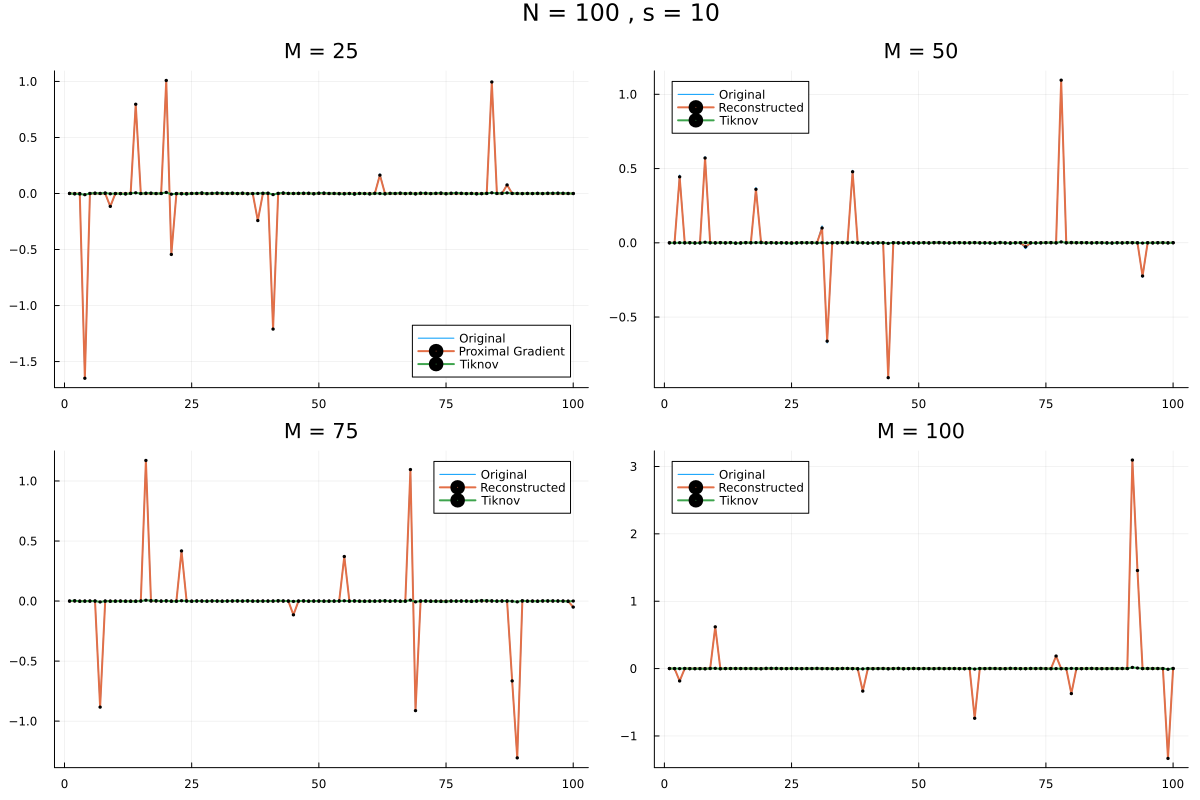

In [7]:
p = .10
x1 , x1_rec , x_tikn1 ,  = X_Rec( p , q1 , N )
x2 , x2_rec , x_tikn2 ,  = X_Rec( p , q2 , N )
x3 , x3_rec , x_tikn3 ,  = X_Rec( p , q3 , N )
x4 , x4_rec , x_tikn4 ,  = X_Rec( p , q4 , N )

p1 = plot( x1 , label = "Original" , title = "M = $(round(Int , q1 * N)  )" )
plot!( x1_rec , label = "Proximal Gradient" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn1 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p2 = plot( x2 , label = "Original" , title = "M = $(round(Int , q2 * N)  )" )
plot!( x2_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn2 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p3 = plot( x3 , label = "Original" , title = "M = $(round(Int , q3 * N)  )" )
plot!( x3_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn3 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p4 = plot( x4 , label = "Original" , title = "M = $(round(Int , q4 * N)  )" )
plot!( x4_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn4 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

plot(p1, p2, p3, p4, size = (1200, 800) , suptitle = "N = $(N) , s = $(round(Int , p * N ))")

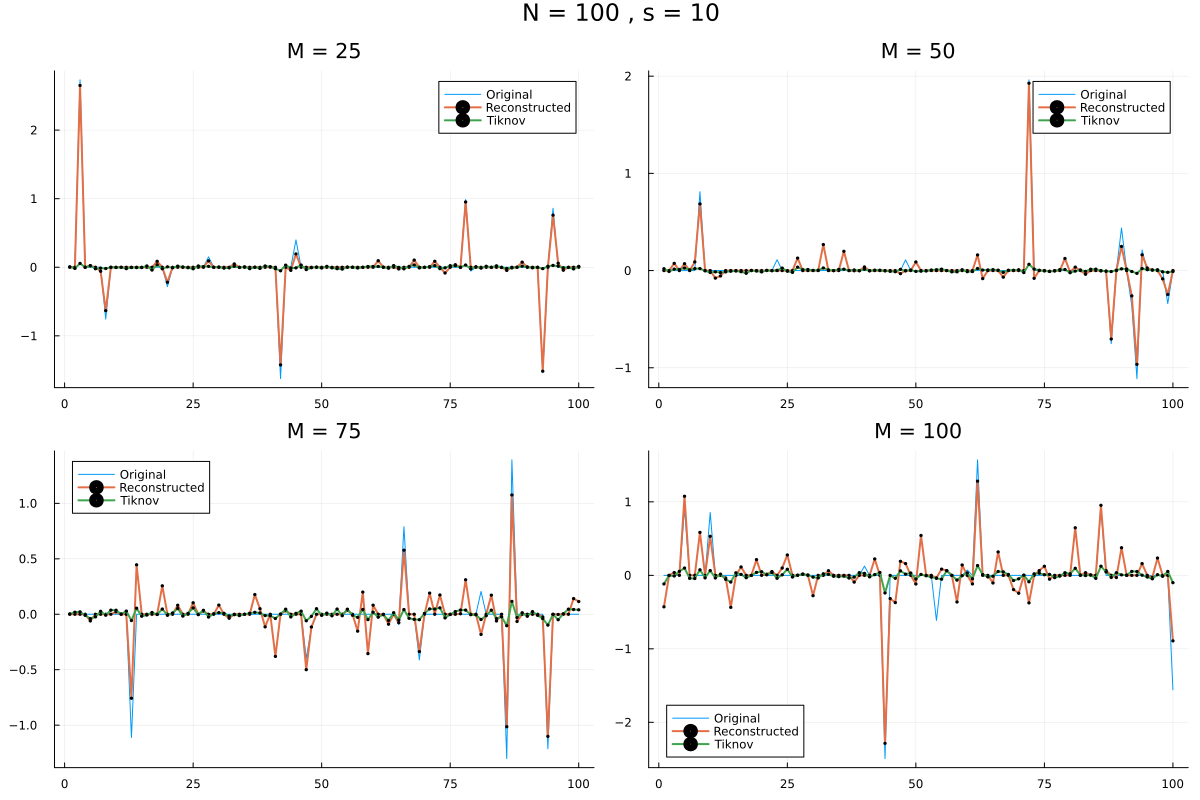

In [31]:
x1 , x1_rec , x_tikn1 ,  = X_Rec( p , q1 , N , σ = .05)
x2 , x2_rec , x_tikn2 ,  = X_Rec( p , q2 , N , σ = .10)
x3 , x3_rec , x_tikn3 ,  = X_Rec( p , q3 , N , σ = .20)
x4 , x4_rec , x_tikn4 ,  = X_Rec( p , q4 , N , σ = .25)

p1 = plot( x1 , label = "Original" , title = "M = $(round(Int , q1 * N)  )" )
plot!( x1_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn1 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p2 = plot( x2 , label = "Original" , title = "M = $(round(Int , q2 * N)  )" )
plot!( x2_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn2 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p3 = plot( x3 , label = "Original" , title = "M = $(round(Int , q3 * N)  )" )
plot!( x3_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn3 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p4 = plot( x4 , label = "Original" , title = "M = $(round(Int , q4 * N)  )" )
plot!( x4_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn4 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

plot(p1, p2, p3, p4, size = (1200, 800) , suptitle = "N = $(N) , s = $(round(Int , p * N ))")

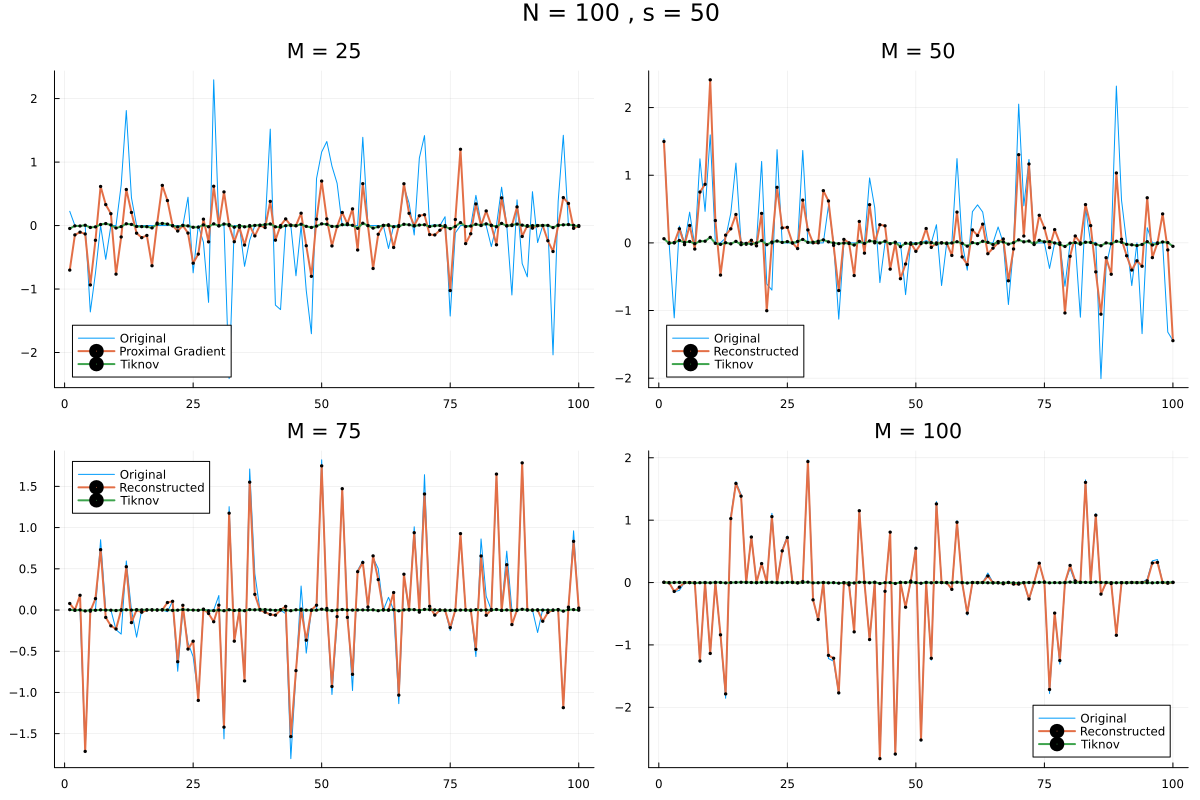

In [32]:
p = .5
x1 , x1_rec , x_tikn1 ,  = X_Rec( p , q1 , N )
x2 , x2_rec , x_tikn2 ,  = X_Rec( p , q2 , N )
x3 , x3_rec , x_tikn3 ,  = X_Rec( p , q3 , N )
x4 , x4_rec , x_tikn4 ,  = X_Rec( p , q4 , N )

p1 = plot( x1 , label = "Original" , title = "M = $(round(Int , q1 * N)  )" )
plot!( x1_rec , label = "Proximal Gradient" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn1 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p2 = plot( x2 , label = "Original" , title = "M = $(round(Int , q2 * N)  )" )
plot!( x2_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn2 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p3 = plot( x3 , label = "Original" , title = "M = $(round(Int , q3 * N)  )" )
plot!( x3_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn3 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p4 = plot( x4 , label = "Original" , title = "M = $(round(Int , q4 * N)  )" )
plot!( x4_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn4 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

plot(p1, p2, p3, p4, size = (1200, 800) , suptitle = "N = $(N) , s = $(round(Int , p * N ))")

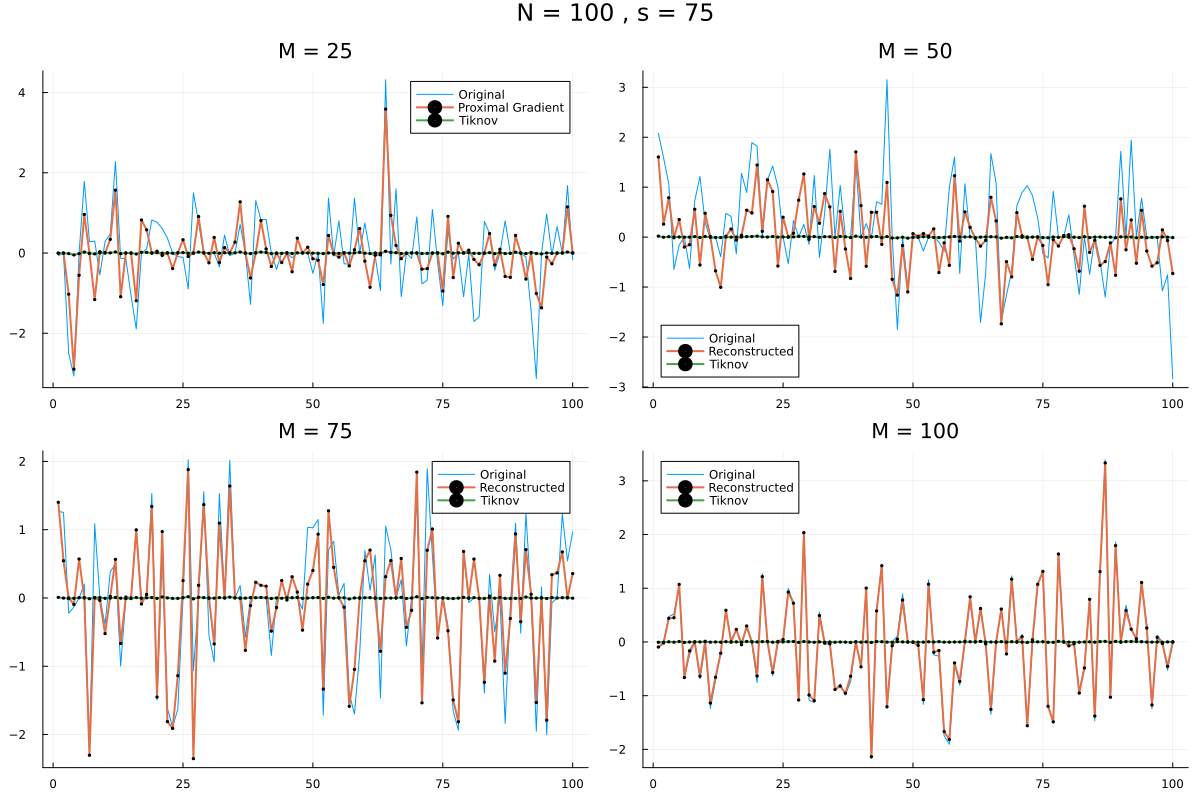

In [33]:
p = .75
x1 , x1_rec , x_tikn1 ,  = X_Rec( p , q1 , N )
x2 , x2_rec , x_tikn2 ,  = X_Rec( p , q2 , N )
x3 , x3_rec , x_tikn3 ,  = X_Rec( p , q3 , N )
x4 , x4_rec , x_tikn4 ,  = X_Rec( p , q4 , N )

p1 = plot( x1 , label = "Original" , title = "M = $(round(Int , q1 * N)  )" )
plot!( x1_rec , label = "Proximal Gradient" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn1 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p2 = plot( x2 , label = "Original" , title = "M = $(round(Int , q2 * N)  )" )
plot!( x2_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn2 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p3 = plot( x3 , label = "Original" , title = "M = $(round(Int , q3 * N)  )" )
plot!( x3_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn3 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p4 = plot( x4 , label = "Original" , title = "M = $(round(Int , q4 * N)  )" )
plot!( x4_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn4 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

plot(p1, p2, p3, p4, size = (1200, 800) , suptitle = "N = $(N) , s = $(round(Int , p * N ))")

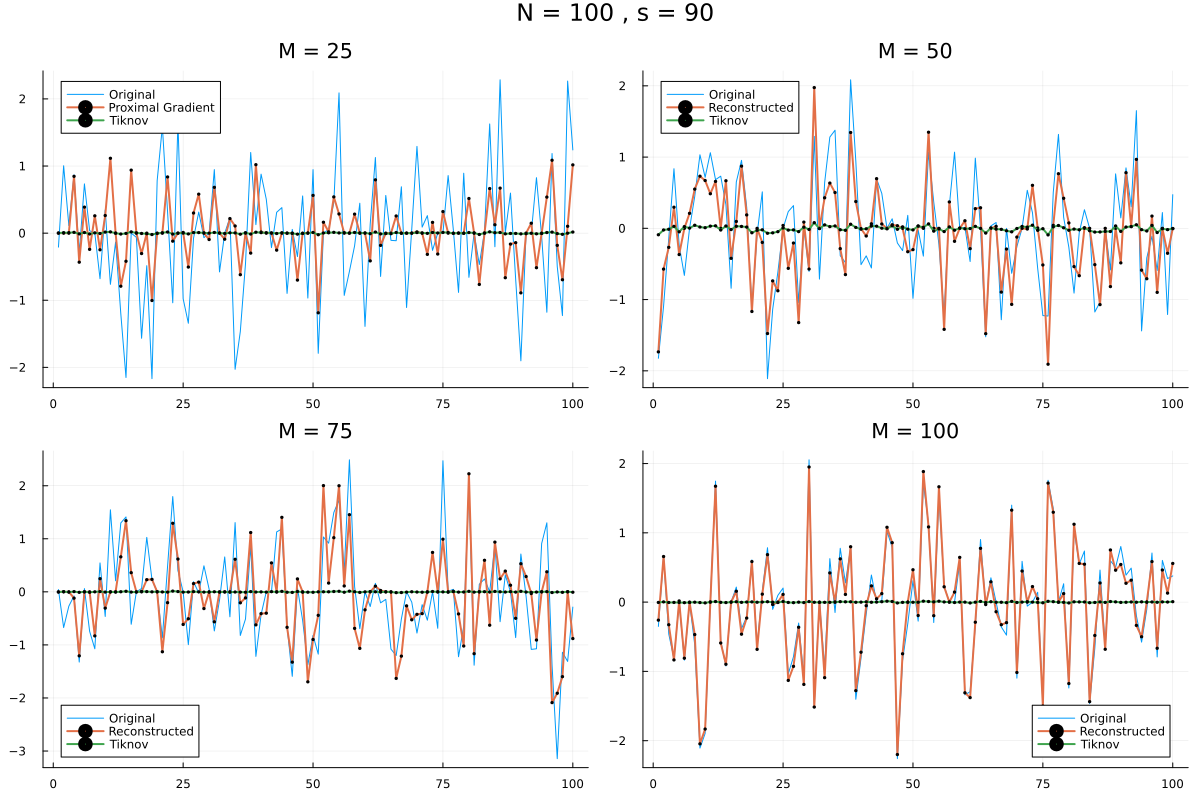

In [34]:
p = .90
x1 , x1_rec , x_tikn1 ,  = X_Rec( p , q1 , N )
x2 , x2_rec , x_tikn2 ,  = X_Rec( p , q2 , N )
x3 , x3_rec , x_tikn3 ,  = X_Rec( p , q3 , N )
x4 , x4_rec , x_tikn4 ,  = X_Rec( p , q4 , N )

p1 = plot( x1 , label = "Original" , title = "M = $(round(Int , q1 * N)  )" )
plot!( x1_rec , label = "Proximal Gradient" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn1 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p2 = plot( x2 , label = "Original" , title = "M = $(round(Int , q2 * N)  )" )
plot!( x2_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1 )
plot!( x_tikn2 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p3 = plot( x3 , label = "Original" , title = "M = $(round(Int , q3 * N)  )" )
plot!( x3_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn3 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

p4 = plot( x4 , label = "Original" , title = "M = $(round(Int , q4 * N)  )" )
plot!( x4_rec , label = "Reconstructed" , lw = 2  , marker = :circle , markersize = 1)
plot!( x_tikn4 , label = "Tiknov" , lw = 2  , marker = :circle , markersize = 1 )

plot(p1, p2, p3, p4, size = (1200, 800) , suptitle = "N = $(N) , s = $(round(Int , p * N ))")